From Rxx, and Gideon, I learned about this applied SME signal boosting on quadradic funding. 

It means that the quadradic funding algorithm is weighted heavier from donors that qualify as SME.

Congrats to the TEC coordination team for pulling this off. They pulled this off on round 1.

Let's apply engineering to this process.

Engineering is about the production of artifacts in a safe and ethical way. 

Artifacts have interfaces that people may use. Engineering allows the usage of interfaces without bad things happening.



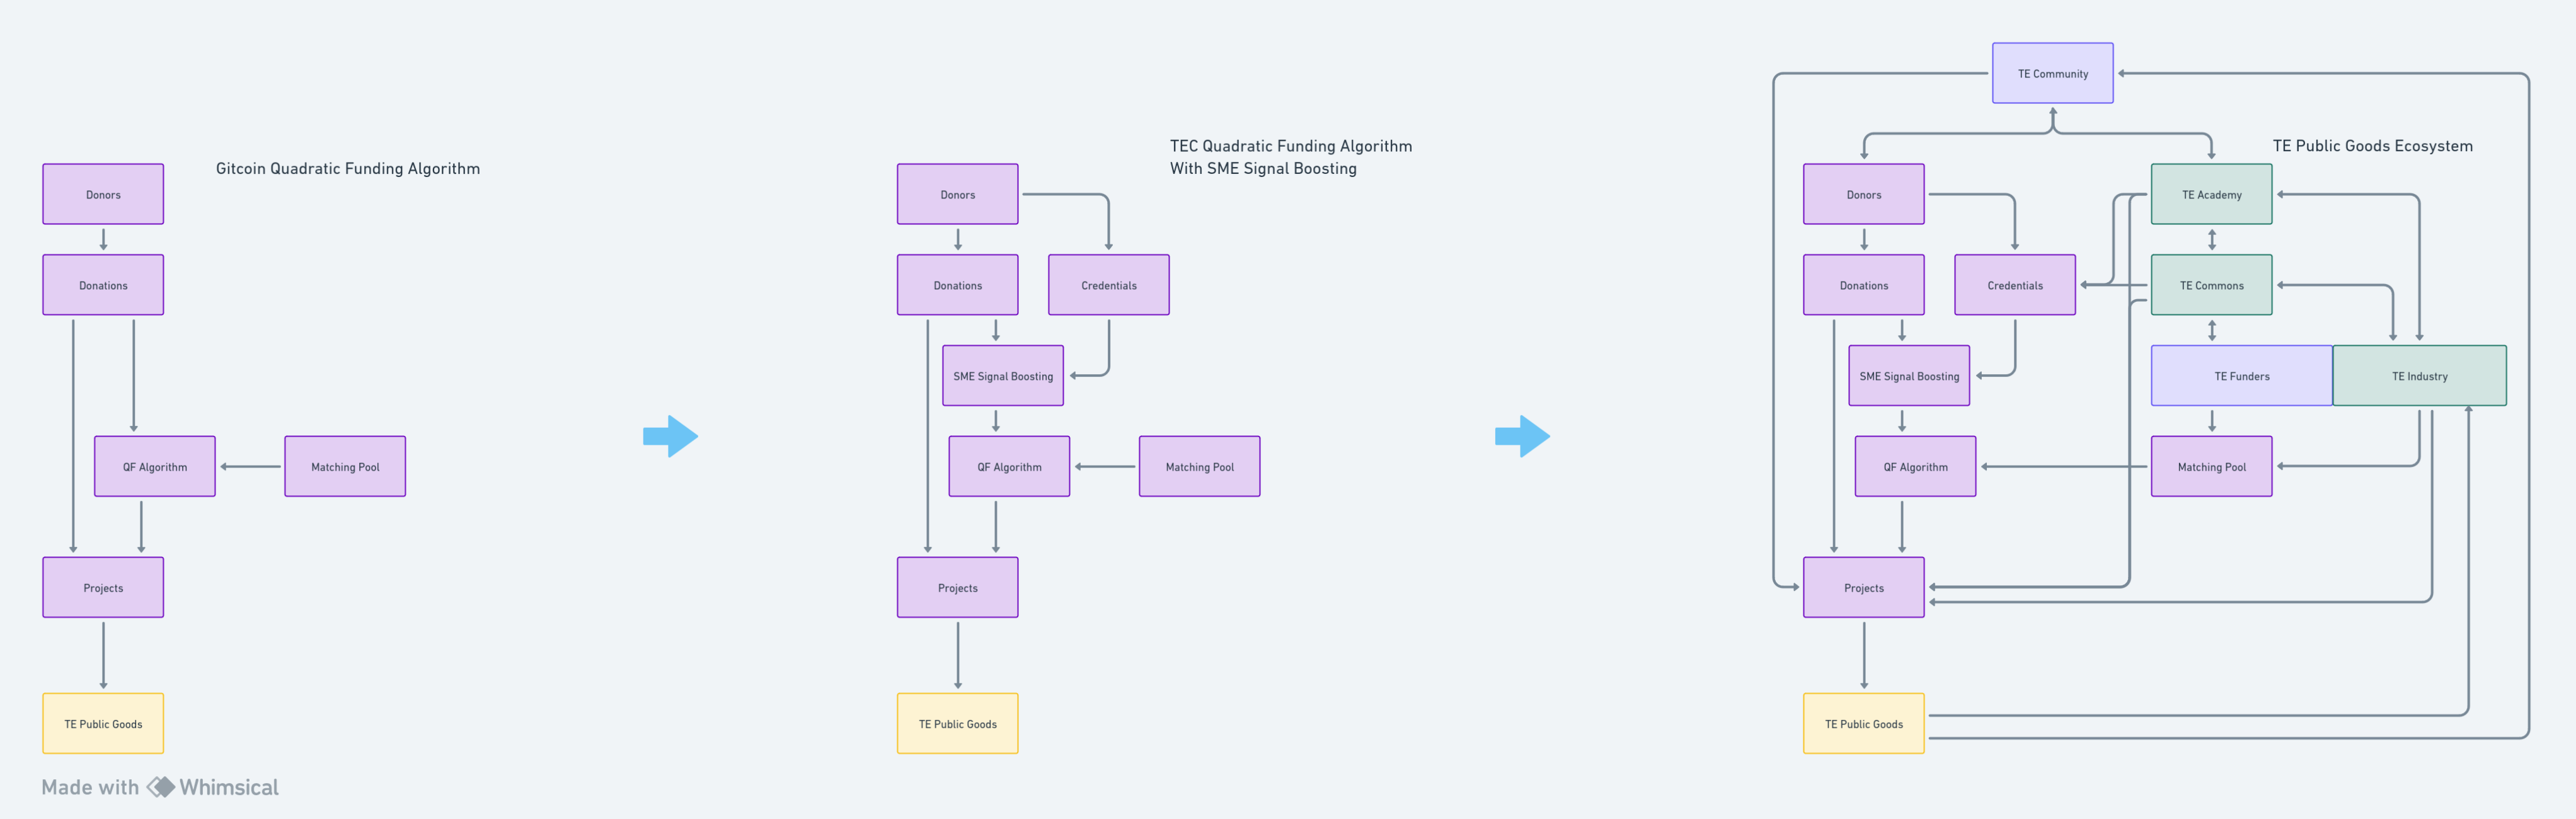![image.png]()

Link to the above board: https://whimsical.com/original-qfsme-mechanism-flowchart-QjXRdbkFmBcXBhnV175K9z 

Resources


* https://arxiv.org/pdf/2010.01193.pdf
* https://arxiv.org/pdf/1809.06421.pdf
* https://vitalik.ca/general/2019/12/07/quadratic.html
* https://qf.gitcoin.co/?grant=&grant=&grant=&match=1000
* https://medium.com/token-engineering-commons/expertise-and-quadratic-funding-bd4f0c5c3e23 

## A Flexible Design for Funding Public Goods

https://arxiv.org/pdf/1809.06421.pdf

### 3.0 Model

In [1]:
import numpy as np

# Number of Citizens in the Society
N = 30

# Society is a set of citizens
society = list(range(N))

# Community is a random subset of the society. The community size is from 25 up to size of the society.
community = np.random.choice(a=list(society), size=np.random.randint(25, len(society)), replace=False, p=None)

# Public Goods are proposed by community members. Cardinality is from 20 up to size of the community.
public_goods = list(enumerate(np.random.choice(a=list(community), size=np.random.randint(20, len(community)), replace=True, p=None)))

In [2]:
community

array([13,  9, 28, 22,  4, 27,  8, 16, 11, 24,  5,  1, 10,  2, 29,  3, 26,
       19, 14,  7, 18, 25, 17,  0, 21, 23, 12])

In [3]:
public_goods

[(0, 19),
 (1, 12),
 (2, 11),
 (3, 1),
 (4, 26),
 (5, 27),
 (6, 5),
 (7, 25),
 (8, 7),
 (9, 21),
 (10, 2),
 (11, 1),
 (12, 1),
 (13, 12),
 (14, 1),
 (15, 7),
 (16, 10),
 (17, 11),
 (18, 16),
 (19, 22),
 (20, 3),
 (21, 19),
 (22, 11)]

In [4]:
len(society)

30

In [5]:
len(community)

27

In [6]:
len(public_goods)

23

### 3.1 Individual Preferences and Actions

The paper calls for Concave, Smooth, Increasing preferences towards the funding of public goods.

The concave value generator has the following properties:
1. f0 = f(0) is in [0,1]
2. f1 = f(1) is in [f0,1]
3. f(x) = 1 - e**(-s*x)
4. The negative exponential function provides a smooth, concave, increasing function from f0 to f1 with a parameterized steepness.

In [7]:
import param
import numpy as np
import panel as pn
import hvplot.pandas
import pandas as pd

class ConcaveFunctionGenerator(param.Parameterized):
    f0 = param.Number(default=0.2, bounds=(0, 1), doc="Value of f(0)")
    f1 = param.Number(default=0.8, bounds=(0, 1), softbounds=(0, 1), doc="Value of f(1)")
    steepness = param.Number(default=5, bounds=(1, 20), doc="Steepness of the curve")

    def __init__(self, **params):
        super().__init__(**params)
        self._update_f1_bounds()

    @param.depends('f0', watch=True)
    def _update_f1_bounds(self):
        # Clip the value of f1 if it's below f0
        self.f1 = max(self.f0, self.f1)
        
        # Update the lower bound of f1 to be the value of f0
        self.param['f1'].bounds = (self.f0, 1)
        
    def x(self):
        return np.linspace(0, 1, 400)

    @param.depends('f0', 'f1', 'steepness')
    def f(self, x):
        # Using the negative exponential function as a base
        y = 1 - np.exp(-self.steepness * x)
        
        # Adjusting the function to start at f0 and end at f1
        y = self.f0 + (self.f1 - self.f0) * (y - y.min()) / (y.max() - y.min())
        
        return y

    @param.depends('f0', 'f1', 'steepness')
    def view(self):
        x = self.x()
        y = self.f(x)
        df = pd.DataFrame({'x': x, 'y': y})
        return df.hvplot.line(x='x', y='y', ylim=(0, 1.01))

concave_gen = ConcaveFunctionGenerator()
pn.Row(concave_gen.param, concave_gen.view).servable()


Row
    [0] Column(margin=(5, 10), name='ConcaveFunctionGenerator'...)
        [0] StaticText(value='<b>ConcaveFunctionGenerat...)
        [1] FloatSlider(name='F0', value=0.2)
        [2] FloatSlider(name='F1', start=0.2, value=0.8)
        [3] FloatSlider(end=20, name='Steepness', start=1, value=5)
    [1] ParamMethod(method, _pane=HoloViews, defer_load=False)

The class dynamically clips f1 to satisfy property 2. Such as in the following example:

In [8]:
ConcaveFunctionGenerator(f0=1,f1=0)

ConcaveFunctionGenerator(f0=1, f1=1, name='ConcaveFunctionGenerator00955', steepness=5)

Here we propose parameter generators for sampling concave functions

In [9]:
import numbergen as ng
import numpy as np


# For CurveGenerator
def concave_function_parameters_generator():
    return dict(
        f0=ng.BoundedNumber(generator=ng.NormalRandom(mu=0.1, sigma=0.3), bounds=(0,1))(),
        f1=ng.BoundedNumber(generator=ng.NormalRandom(mu=0.5, sigma=0.4), bounds=(0,1))(),
        steepness=ng.UniformRandom(lbound=1, ubound=20)(),
    )

This method generates random parameters given the distributions described for f0, f1, and steepness above. 
* f0 is a normal distribution at (0.1,0.3), clipped at (0,1)
* f0 is a normal distribution at (0.5,0.4), clipped at (0,1)
* steepness is a uniform distribution at (1,20)

In [10]:
concave_function_parameters_generator()

{'f0': 0, 'f1': 0.3716503911379197, 'steepness': 18.7970296283873}

In [11]:
value_functions = [ConcaveFunctionGenerator(**concave_function_parameters_generator()) for p_i in range(len(public_goods)*len(society))]

Here we can see all of the preferences of the citizens. These are the value functions V_p_i(F_p). There is one preference function for each V_p_i in {public_goods}X{citizens}. Cardinality is len(public_goods)*len(citizens).

In [12]:
import pandas as pd

pd.DataFrame([s.param.values() for s in value_functions])

sample_p_i_slider = pn.widgets.IntSlider(name='Utility Value Function', start=0, end=len(value_functions)-1)

pn.Row(sample_p_i_slider, pn.bind(lambda i: value_functions[i].view(), i=sample_p_i_slider))

Row
    [0] IntSlider(end=689, name='Utility Value Function')
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False)

Create a Dataframe! These are citizen preferences by funding amounts for public goods. Take Funding Amount as the Index by applying a transpose. 

In [13]:
df_value_functions = pd.DataFrame([s.f(s.x()) for s in value_functions])
df_value_functions = df_value_functions.T
df_value_functions.shape

(400, 690)

Make Funding the Index from 0 to 100

In [14]:
df_value_functions.index = np.linspace(0,1,len(df_value_functions))
df_value_functions.index.name = "funding"

Label the Columns by {public_goods}X{Citizens}.

In [15]:
df_value_functions.columns = [(p, i) for p in public_goods for i in society]
df_value_functions.columns.name = "value_p_i"


Number of columns is len(public_goods)*len(society).

In [16]:
df_value_functions

value_p_i,"((0, 19), 0)","((0, 19), 1)","((0, 19), 2)","((0, 19), 3)","((0, 19), 4)","((0, 19), 5)","((0, 19), 6)","((0, 19), 7)","((0, 19), 8)","((0, 19), 9)",...,"((22, 11), 20)","((22, 11), 21)","((22, 11), 22)","((22, 11), 23)","((22, 11), 24)","((22, 11), 25)","((22, 11), 26)","((22, 11), 27)","((22, 11), 28)","((22, 11), 29)"
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,0.000000,0.373756,0.000000,0.567814,0.006265,0.129949,0.682948,0.117009,0.232990,0.079306,...,0.364090,0.274586,0.178793,0.000000,0.000000,0.0,0.236877,0.000000,0.259868,0.0
0.002506,0.042928,0.375340,0.009101,0.571972,0.041723,0.136706,0.682948,0.139129,0.248131,0.080571,...,0.371733,0.280727,0.178793,0.010090,0.008330,0.0,0.236877,0.000731,0.259868,0.0
0.005013,0.084013,0.376919,0.017852,0.576091,0.075472,0.143344,0.682948,0.160321,0.262579,0.081822,...,0.379270,0.286658,0.178793,0.020051,0.016593,0.0,0.236877,0.001458,0.259868,0.0
0.007519,0.123335,0.378494,0.026266,0.580171,0.107595,0.149863,0.682948,0.180624,0.276365,0.083059,...,0.386701,0.292388,0.178793,0.029884,0.024790,0.0,0.236877,0.002183,0.259868,0.0
0.010025,0.160969,0.380064,0.034356,0.584213,0.138170,0.156267,0.682948,0.200074,0.289521,0.084283,...,0.394028,0.297922,0.178793,0.039591,0.032921,0.0,0.236877,0.002904,0.259868,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,1.000000,0.759499,0.236468,0.999607,0.742069,0.509435,0.682948,0.644171,0.563878,0.192351,...,0.908460,0.454732,0.178793,0.781320,0.998616,0.0,0.236877,0.142704,0.259868,0.0
0.992481,1.000000,0.760046,0.236468,0.999706,0.742069,0.509441,0.682948,0.644171,0.563878,0.192367,...,0.908489,0.454732,0.178793,0.781381,0.998966,0.0,0.236877,0.142848,0.259868,0.0
0.994987,1.000000,0.760592,0.236468,0.999805,0.742069,0.509446,0.682948,0.644171,0.563878,0.192382,...,0.908518,0.454732,0.178793,0.781442,0.999313,0.0,0.236877,0.142990,0.259868,0.0


Display Citizen Preferences for Funding.

In [17]:
# df_value_functions.hvplot.line(x='funding', color='blue', alpha=0.1, line_width=3, ylabel='Value to Citizens', title='Smooth, Concave, Increasing Value Functions')

Mean preferences for funding public goods.

In [18]:
df_value_functions['mean'] = df_value_functions.mean(axis=1)
df_value_functions['std'] = df_value_functions.std(axis=1)
df_value_functions['low'] = df_value_functions['mean'] - df_value_functions['std']
df_value_functions['high'] = df_value_functions['mean'] + df_value_functions['std']

df_value_functions.hvplot.line(y='mean', ylabel='Value to Society') * df_value_functions.hvplot.area(y='low',y2='high', alpha=0.5, title='Mean Value to Society Given Funding')

:Overlay
   .Curve.I :Curve   [funding]   (mean)
   .Area.I  :Area   [funding]   (low,high)

Moving on..

In [19]:
df_value_functions.drop(['mean','std','low','high'],axis=1,inplace=True)

Melting preferences to get groupby on public good or on citizen.

In [20]:
df_value_functions_melted = df_value_functions.melt(ignore_index=False)
df_value_functions_melted['public_good'] = df_value_functions_melted['value_p_i'].astype(str).apply(eval).apply(lambda x: x[0]).astype(str)
df_value_functions_melted['citizen'] = df_value_functions_melted['value_p_i'].astype(str).apply(eval).apply(lambda x: x[1]).astype(str)
df_value_functions_melted

,value_p_i,value,public_good,citizen
funding,,,,
0.000000,"((0, 19), 0)",0.000000,"(0, 19)",0
0.002506,"((0, 19), 0)",0.042928,"(0, 19)",0
0.005013,"((0, 19), 0)",0.084013,"(0, 19)",0
0.007519,"((0, 19), 0)",0.123335,"(0, 19)",0
0.010025,"((0, 19), 0)",0.160969,"(0, 19)",0
...,...,...,...,...
0.989975,"((22, 11), 29)",0.000000,"(22, 11)",29
0.992481,"((22, 11), 29)",0.000000,"(22, 11)",29
0.994987,"((22, 11), 29)",0.000000,"(22, 11)",29


Groupby funding and public good to get mean funding preferences per public good.

In [21]:
mean_utility_df = df_value_functions_melted.groupby(['funding', 'public_good'])[['value']].mean().reset_index()

Display mean value function per public good.

In [22]:
mean_utility_df.hvplot.line(y='value', by='public_good', alpha=0.8, line_width=4, x='funding', title='Mean Value to Society per Public Good Given Funding')

:NdOverlay   [public_good]
   :Curve   [funding]   (value)

Display mean value function per citizen.

In [23]:
mean_utility_df2 = df_value_functions_melted.groupby(['funding', 'citizen'])[['value']].mean().reset_index()

In [24]:
mean_utility_df2.hvplot.line(y='value', by='citizen', alpha=0.8, line_width=4, x='funding', title='Mean Public Good Preference Value Function per Citizen')

:NdOverlay   [citizen]
   :Curve   [funding]   (value)

Each citizen i can make contributions to the funding of each public good p out of their resources c_p_i. The total utility then of citizen i is: [sum(V_p_i(F_p))  - c_p_i - t_i for all p in public_goods]

To calculate the above, we need F_p which is a vector of how much funding is achieved by each public good. We can sample a distribution of funding ammounts.

### 3.1 Side Quest: Funding Generator

### Funding Generator Per Public Good.

In [25]:
public_goods_funding_model = {'constant_value': 0.5,
 'distribution_type': 'exponential',
 'lambda_param': 2.8000000000000003,
 'mean': 0.2,
 'n': len(public_goods),
 'name': 'PublicGoodsFundingDistributionGenerator53483',
 'std_dev': 0.2}

In [26]:
import param
import numpy as np
import pandas as pd
import panel as pn
import hvplot.pandas

class PublicGoodsFundingDistributionGenerator(param.Parameterized):
    distribution_type = param.ObjectSelector(default="normal", objects=["normal", "constant", "uniform", "exponential"])
    mean = param.Number(default=0.5, bounds=(0, 1))
    n = param.Integer(default=100, bounds=(1, 1000))
    
    # Additional parameters for specific distributions
    std_dev = param.Number(default=0.1, bounds=(0, 0.5))  # for normal distribution
    constant_value = param.Number(default=0.5, bounds=(0, 1))  # for constant distribution
    lambda_param = param.Number(default=1.0, bounds=(0.1, 5))  # for exponential distribution
    
    @param.depends('distribution_type', 'mean', 'n', 'std_dev', 'constant_value', 'lambda_param')
    def generate_distribution(self):
        if self.distribution_type == "normal":
            distribution = np.clip(np.random.normal(self.mean, self.std_dev, self.n), 0, 1)
        elif self.distribution_type == "constant":
            distribution = np.full(self.n, self.constant_value)
        elif self.distribution_type == "uniform":
            distribution = np.random.uniform(0, 1, self.n)
        elif self.distribution_type == "exponential":
            distribution = np.clip(np.random.exponential(1/self.lambda_param, self.n), 0, 1)
        return distribution #/ distribution.sum()
        
    
    @param.depends('distribution_type', 'mean', 'n', 'std_dev', 'constant_value', 'lambda_param')
    def view(self):
        data = self.generate_distribution()
        df = pd.DataFrame({'Value': data})
        return df.hvplot.hist('Value', bins=30, xlim=(0, 1), title='Public Goods Funding Histogram')

# Create an instance
dist_gen = PublicGoodsFundingDistributionGenerator(**public_goods_funding_model)

# Use panel to render the interactive system
pn.Row(dist_gen.param, dist_gen.view).servable()


Row
    [0] Column(margin=(5, 10), name='PublicGoodsFundingDistrib...)
        [0] StaticText(value='<b>PublicGoodsFundingDist...)
        [1] Select(name='Distribution type', options=OrderedDict([('normal', ...]), value='exponential')
        [2] FloatSlider(name='Mean', value=0.2)
        [3] IntSlider(end=1000, name='N', start=1, value=23)
        [4] FloatSlider(end=0.5, name='Std dev', value=0.2)
        [5] FloatSlider(name='Constant value', value=0.5)
        [6] FloatSlider(end=5, name='Lambda param', start=0.1, value=2.8000000000000003)
    [1] ParamMethod(method, _pane=HoloViews, defer_load=False)

In [27]:
dist_gen.param.values()

{'constant_value': 0.5,
 'distribution_type': 'exponential',
 'lambda_param': 2.8000000000000003,
 'mean': 0.2,
 'n': 23,
 'name': 'PublicGoodsFundingDistributionGenerator53483',
 'std_dev': 0.2}

In [28]:
public_goods_funding_distribution = pd.Series(dist_gen.generate_distribution(), name='Public Goods Funding Distribution')
public_goods_funding_distribution = public_goods_funding_distribution / public_goods_funding_distribution.sum()

In [29]:
public_goods_funding_distribution

0     0.002169
1     0.045512
2     0.001562
3     0.015675
4     0.120032
5     0.043253
6     0.004517
7     0.102048
8     0.024125
9     0.017955
10    0.120032
11    0.028653
12    0.048030
13    0.087118
14    0.120032
15    0.034700
16    0.004946
17    0.086626
18    0.040223
19    0.010978
20    0.008912
21    0.000520
22    0.032383
Name: Public Goods Funding Distribution, dtype: float64

In [30]:
public_goods_funding_distribution.shape

(23,)

In [31]:
public_goods_funding_distribution.sum()

1.0

### Public Goods Funding Generator Simplified - Pareto

In [32]:
import numpy as np

def generate_pareto(n, alpha=2):
    # Generate Pareto samples
    samples = np.random.pareto(alpha, n)
    
    # Normalize to make them sum to 1
    normalized_samples = samples / samples.sum()
    
    # Clip values to [0,1]
    clipped_samples = np.clip(normalized_samples, 0, 1)
    
    # Adjust to ensure they still sum to 1 after clipping
    clipped_samples /= clipped_samples.sum()
    
    return clipped_samples

n = len(public_goods)
pareto_samples = generate_pareto(n)


In [33]:
pd.DataFrame(pareto_samples).sort_values(0,ascending=False).reset_index(drop=True).hvplot(title='Public Goods Funding Distribution', xlabel='Public Good', ylabel='Funding')

:Curve   [index]   (0)

In [34]:
public_goods_funding_distribution = pd.Series(pareto_samples, name='Public Goods Funding Distribution')
public_goods_funding_distribution

0     0.004495
1     0.000419
2     0.018841
3     0.111203
4     0.006474
5     0.186931
6     0.010184
7     0.018046
8     0.009119
9     0.035784
10    0.085558
11    0.191725
12    0.001289
13    0.036747
14    0.023177
15    0.006474
16    0.011945
17    0.000959
18    0.000029
19    0.024660
20    0.011067
21    0.003883
22    0.200992
Name: Public Goods Funding Distribution, dtype: float64

In [35]:
public_goods_funding_distribution.shape

(23,)

In [36]:
public_goods_funding_distribution.sum()

1.0

### Citizen Funding Model

Given a citizen i, this model selects a k public goods to donate to. The number of public goods to donate to is sampled from a beta decay centered at 8 in range [1,len(public_goods)].

Once k is sampled, a normal distribution of size k is sampled, and padded with 0s to be of size n. Then all is shuffled to distribute 0s randomly.

In [37]:
import numpy as np
from icecream import ic
ic.configureOutput(prefix='ic|',outputFunction=print)

n = len(public_goods)
ic(n)
k = int(np.clip(np.random.exponential(8), 1, n))
ic(k)
distribution = np.pad(np.abs(np.random.normal(size=k)), (0, n-k))
np.random.shuffle(distribution)
distribution /= distribution.sum()

ic|n: 23
ic|k: 23


In [38]:
import param
import panel as pn
import hvplot.pandas
import pandas as pd
import numpy as np
from icecream import ic

ic.configureOutput(prefix='ic|', outputFunction=print)

class CustomDistributionGenerator(param.Parameterized):
    n = param.Integer(default=100, bounds=(1, 1000), constant=True)
    mean_exponential = param.Integer(default=4, bounds=(1, 50))
    data = param.Array(precedence=-1)
    
    def __init__(self, **params):
        super().__init__(**params)
        self.generate_distribution()
    
    def f(self):
        k = int(np.clip(np.random.exponential(self.mean_exponential), 1, self.n))
        distribution = np.pad(np.abs(np.random.normal(size=k)), (0, self.n-k))
        np.random.shuffle(distribution)
        distribution /= distribution.sum()
        return distribution
    
    def x(self):
        return np.arange(self.n)
    
    @param.depends('n', 'mean_exponential', watch=True)
    def generate_distribution(self):
        self.data = self.f()
    
    @param.depends('data')
    def view(self):
        df = pd.DataFrame({'Value': self.data})
        return df.hvplot.step('index', 'Value', xlim=(0, self.n), ylim=(0, 1.01), title='Sample Public Goods Funding Amounts by Citizin I')

# Create an instance
dist_gen = CustomDistributionGenerator(n=len(public_goods))

# Use panel to render the interactive system
pn.Row(dist_gen.param, dist_gen.view).servable()


Row
    [0] Column(margin=(5, 10), name='CustomDistributionGenerat...)
        [0] StaticText(value='<b>CustomDistributionGene...)
        [1] IntSlider(disabled=True, end=1000, name='N', start=1, value=23)
        [2] IntSlider(end=50, name='Mean exponential', start=1, value=4)
    [1] ParamMethod(method, _pane=HoloViews, defer_load=False)

The above can be used to sample a contributions vector for each citizen to generate the contributions matrix. The matrix should be {society}X{public_good}

In [39]:
len(public_goods)

23

In [40]:
len(society)

30

Generate public goods funding contributions for each citizen in the society.

In [41]:
contributions = pd.DataFrame([CustomDistributionGenerator(n=len(public_goods)).data for i in society])

contributions.columns.name = 'Public Good'
contributions.index.name = 'Citizen'

contributions

Public Good,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
Citizen,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000
2,0.000000,0.000000,0.016162,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.643649,0.000000,0.000000,0.340189,0.0,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.0,0.140389,0.091212,0.0,0.000000,0.386367,0.041919,...,0.214696,0.000000,0.000000,0.000000,0.000000,0.125418,0.000000,0.0,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.0,0.537492,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.068742,0.000000,0.000000,0.000000,0.000000,0.393767,0.0,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8,0.000000,0.225753,0.000000,0.0,0.021586,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.516435


In [42]:
contributions.sum()

Public Good
0     1.002134
1     0.314282
2     0.219361
3     1.000000
4     2.391064
5     2.533885
6     0.000000
7     0.792871
8     1.223075
9     1.420424
10    2.701658
11    5.780560
12    0.236227
13    0.310594
14    1.171634
15    0.362691
16    0.643649
17    0.718171
18    1.125418
19    0.767011
20    2.000000
21    2.392424
22    0.892866
dtype: float64

In [43]:
contributions.sum(axis=1)

Citizen
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
dtype: float64

In [44]:
contributions.sum().sum()

30.0

In [45]:
h1 = contributions.hvplot.heatmap(title="Contributions", cmap='Reds', fontscale=1.2, width=800, height=800, xlabel='Public Good', ylabel='Citizen', clabel='Amount Contributed from citizen i to public_good p.').opts(default_tools=[])
h1

:HeatMap   [columns,index]   (value)

In [46]:
public_goods_funding = (contributions / contributions.sum(axis=0))

In [47]:
public_goods_funding.sum(axis=0)

Public Good
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     0.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
dtype: float64

In [48]:
public_goods_funding.sum(axis=1)

Citizen
0     0.172994
1     0.888559
2     1.517203
3     0.394651
4     1.242804
5     0.796841
6     0.853509
7     0.172994
8     2.305742
9     0.704015
10    0.172994
11    1.075931
12    0.417986
13    0.172994
14    1.000000
15    0.643404
16    1.203389
17    1.391116
18    0.861657
19    0.432877
20    0.831294
21    0.407656
22    0.418224
23    0.370143
24    0.394651
25    1.658977
26    0.500000
27    0.500000
28    0.198481
29    0.298914
dtype: float64

In [49]:
public_goods_funding.sum().sum()

22.0

In [50]:
h2 = public_goods_funding.hvplot.heatmap(title="Contributions", cmap='Reds', fontscale=1.2, width=800, height=800, xlabel='Public Good', ylabel='Citizen', clabel='Amount Contributed from citizen i to public_good p.').opts(default_tools=[])
h2

:HeatMap   [columns,index]   (value)

In [51]:
h1 + h2

:Layout
   .HeatMap.I  :HeatMap   [columns,index]   (value)
   .HeatMap.II :HeatMap   [columns,index]   (value)

In [52]:
# Normalize relative to our public_goods funding distribution.
normalized_contributions = contributions * public_goods_funding_distribution / contributions.sum()

In [53]:
h3 = normalized_contributions.hvplot.heatmap(title="Contributions", cmap='Reds', fontscale=1.2, width=800, height=800, xlabel='Public Good', ylabel='Citizen', clabel='Amount Contributed from citizen i to public_good p.').opts(default_tools=[])
h3

:HeatMap   [columns,index]   (value)

In [54]:
normalized_contributions

Public Good,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
Citizen,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000026,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.001388,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.011945,0.000000,0.000000,0.010937,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.073773,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000380,0.006729,NaN,0.000000,0.002881,0.001056,...,0.025401,0.000000,0.000000,0.000000,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.001455,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,0.001360,0.000000,0.000000,0.000000,0.000000,0.012660,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,0.019782,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000301,0.000000,0.000000,0.000058,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.116254


In [55]:
normalized_contributions.sum(axis=0)

Public Good
0     0.004495
1     0.000419
2     0.018841
3     0.111203
4     0.006474
5     0.186931
6     0.000000
7     0.018046
8     0.009119
9     0.035784
10    0.085558
11    0.191725
12    0.001289
13    0.036747
14    0.023177
15    0.006474
16    0.011945
17    0.000959
18    0.000029
19    0.024660
20    0.011067
21    0.003883
22    0.200992
dtype: float64

In [56]:
normalized_contributions.sum(axis=1)

Citizen
0     0.033167
1     0.000026
2     0.024270
3     0.073773
4     0.036450
5     0.015475
6     0.019782
7     0.033167
8     0.117902
9     0.025193
10    0.033167
11    0.041893
12    0.001623
13    0.033167
14    0.111203
15    0.039977
16    0.008209
17    0.065028
18    0.006730
19    0.026961
20    0.003974
21    0.033562
22    0.002708
23    0.031669
24    0.073773
25    0.036049
26    0.005534
27    0.005534
28    0.032898
29    0.016954
dtype: float64

In [57]:
df_value_functions_melted.index = pd.to_numeric(df_value_functions_melted.index, errors='coerce')

In [58]:
def find_closest_value(group):
    # Ensure the index is numeric
    group.index = pd.to_numeric(group.index, errors='coerce')
    
    # Get the index of the closest value
    i = int(group['citizen'].iloc[0])  # Assuming 'citizen' column contains integer values
    
    # Check if the index is valid for public_goods_funding_distribution
    if i >= len(public_goods_funding_distribution):
        return None  # or handle it in another appropriate way
    
    indexer = group.index.get_indexer([public_goods_funding_distribution[i]], method='nearest')
    
    # Retrieve the closest value
    return group.iloc[indexer[0]]

# Apply the custom function to each group
result = df_value_functions_melted.groupby(['citizen', 'value_p_i']).apply(find_closest_value).reset_index(drop=True)


In [59]:
result

,value_p_i,value,public_good,citizen
0,"((0, 19), 0)",0.084013,"(0, 19)",0
1,"((1, 12), 0)",0.079725,"(1, 12)",0
2,"((2, 11), 0)",0.233588,"(2, 11)",0
3,"((3, 1), 0)",0.584833,"(3, 1)",0
4,"((4, 26), 0)",0.616458,"(4, 26)",0
...,...,...,...,...
685,"((18, 16), 9)",0.069971,"(18, 16)",9
686,"((19, 22), 9)",0.048581,"(19, 22)",9
687,"((20, 3), 9)",0.294760,"(20, 3)",9
688,"((21, 19), 9)",0.409889,"(21, 19)",9


In [60]:
public_goods_funding_distribution

0     0.004495
1     0.000419
2     0.018841
3     0.111203
4     0.006474
5     0.186931
6     0.010184
7     0.018046
8     0.009119
9     0.035784
10    0.085558
11    0.191725
12    0.001289
13    0.036747
14    0.023177
15    0.006474
16    0.011945
17    0.000959
18    0.000029
19    0.024660
20    0.011067
21    0.003883
22    0.200992
Name: Public Goods Funding Distribution, dtype: float64

In [61]:
result.groupby('public_good').sum()['value']

public_good
(0, 19)     7.084689
(1, 12)     5.161740
(10, 2)     4.944265
(11, 1)     5.385692
(12, 1)     5.366558
(13, 12)    4.250233
(14, 1)     5.897537
(15, 7)     6.818910
(16, 10)    5.595442
(17, 11)    6.226571
(18, 16)    5.439167
(19, 22)    5.831443
(2, 11)     4.615213
(20, 3)     6.466659
(21, 19)    4.777742
(22, 11)    5.782575
(3, 1)      7.104081
(4, 26)     6.273726
(5, 27)     7.894055
(6, 5)      5.662492
(7, 25)     5.586612
(8, 7)      6.301586
(9, 21)     5.639312
Name: value, dtype: float64

In [62]:
df_value_functions_melted

,value_p_i,value,public_good,citizen
funding,,,,
0.000000,"((0, 19), 0)",0.000000,"(0, 19)",0
0.002506,"((0, 19), 0)",0.042928,"(0, 19)",0
0.005013,"((0, 19), 0)",0.084013,"(0, 19)",0
0.007519,"((0, 19), 0)",0.123335,"(0, 19)",0
0.010025,"((0, 19), 0)",0.160969,"(0, 19)",0
...,...,...,...,...
0.989975,"((22, 11), 29)",0.000000,"(22, 11)",29
0.992481,"((22, 11), 29)",0.000000,"(22, 11)",29
0.994987,"((22, 11), 29)",0.000000,"(22, 11)",29


Mean utility per funding of public good per citizen.

In [63]:
df_value_functions_melted.pivot_table(index='funding', columns='public_good', values='value', aggfunc='mean')

public_good,"(0, 19)","(1, 12)","(10, 2)","(11, 1)","(12, 1)","(13, 12)","(14, 1)","(15, 7)","(16, 10)","(17, 11)",...,"(20, 3)","(21, 19)","(22, 11)","(3, 1)","(4, 26)","(5, 27)","(6, 5)","(7, 25)","(8, 7)","(9, 21)"
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,0.203269,0.163745,0.185529,0.182482,0.161257,0.124320,0.141097,0.259596,0.125129,0.156343,...,0.251361,0.159912,0.168045,0.191826,0.209457,0.180685,0.176637,0.151217,0.187888,0.114426
0.002506,0.214118,0.173103,0.197703,0.193130,0.169480,0.131889,0.151129,0.267363,0.136254,0.167152,...,0.260773,0.167351,0.175387,0.200858,0.215335,0.191352,0.185766,0.159435,0.196060,0.125829
0.005013,0.224594,0.182119,0.209458,0.203423,0.177479,0.139248,0.160863,0.274855,0.147016,0.177626,...,0.269863,0.174576,0.182502,0.209577,0.221023,0.201691,0.194592,0.167399,0.203979,0.136899
0.007519,0.234710,0.190804,0.220809,0.213375,0.185259,0.146404,0.170309,0.282082,0.157429,0.187778,...,0.278643,0.181594,0.189397,0.217995,0.226526,0.211714,0.203125,0.175119,0.211657,0.147648
0.010025,0.244480,0.199173,0.231773,0.222998,0.192828,0.153363,0.179477,0.289054,0.167506,0.197618,...,0.287125,0.188412,0.196081,0.226121,0.231852,0.221434,0.211377,0.182602,0.219101,0.158085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,0.585020,0.461938,0.616293,0.548830,0.546737,0.445489,0.551632,0.538214,0.569091,0.548513,...,0.591328,0.501428,0.494904,0.488948,0.452835,0.645242,0.547782,0.491079,0.557603,0.596374
0.992481,0.585062,0.461957,0.616336,0.548843,0.546808,0.445509,0.551656,0.538278,0.569167,0.548530,...,0.591343,0.501479,0.494954,0.488962,0.452886,0.645303,0.547861,0.491104,0.557687,0.596436
0.994987,0.585104,0.461975,0.616378,0.548857,0.546878,0.445530,0.551679,0.538343,0.569242,0.548547,...,0.591359,0.501530,0.495004,0.488975,0.452936,0.645365,0.547940,0.491130,0.557770,0.596498


Total utility per funding of public good.

In [64]:
df_value_functions_melted.pivot_table(index='funding', columns='public_good', values='value', aggfunc='sum')

public_good,"(0, 19)","(1, 12)","(10, 2)","(11, 1)","(12, 1)","(13, 12)","(14, 1)","(15, 7)","(16, 10)","(17, 11)",...,"(20, 3)","(21, 19)","(22, 11)","(3, 1)","(4, 26)","(5, 27)","(6, 5)","(7, 25)","(8, 7)","(9, 21)"
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,6.098068,4.912339,5.565878,5.474465,4.837700,3.729612,4.232905,7.787875,3.753880,4.690298,...,7.540822,4.797354,5.041356,5.754794,6.283709,5.420541,5.299100,4.536501,5.636653,3.432790
0.002506,6.423546,5.193104,5.931087,5.793886,5.084410,3.956679,4.533865,8.020889,4.087627,5.014549,...,7.823190,5.020519,5.261612,6.025754,6.460059,5.740549,5.572993,4.783052,5.881789,3.774878
0.005013,6.737817,5.463567,6.283725,6.102687,5.324364,4.177453,4.825889,8.245644,4.410494,5.328789,...,8.095881,5.237265,5.475047,6.287318,6.630677,6.050724,5.837762,5.021981,6.119383,4.106984
0.007519,7.041301,5.724132,6.624269,6.401253,5.557774,4.392131,5.109276,8.462456,4.722881,5.633348,...,8.359276,5.447811,5.681911,6.539835,6.795772,6.351429,6.093758,5.253563,6.349710,4.429439
0.010025,7.334404,5.975191,6.953177,6.689953,5.784842,4.600904,5.384314,8.671627,5.025174,5.928543,...,8.613740,5.652368,5.882441,6.783638,6.955548,6.643009,6.341318,5.478062,6.573036,4.742560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,17.550596,13.858130,18.488785,16.464890,16.402115,13.364674,16.548971,16.146420,17.072730,16.455386,...,17.739847,15.042850,14.847112,14.668444,13.585038,19.357245,16.433468,14.732371,16.728105,17.891223
0.992481,17.551868,13.858698,18.490068,16.465299,16.404237,13.365284,16.549681,16.148352,17.075008,16.455895,...,17.740304,15.044375,14.848618,14.668852,13.586566,19.359101,16.435833,14.733134,16.730603,17.893083
0.994987,17.553133,13.859262,18.491344,16.465704,16.406348,13.365890,16.550384,16.150276,17.077274,16.456401,...,17.740757,15.045890,14.850114,14.669256,13.588085,19.360945,16.438187,14.733891,16.733090,17.894935


Mean utility per citizen for funding the commons.

In [65]:
df_value_functions_melted.pivot_table(index='funding', columns='citizen', values='value', aggfunc='mean')

citizen,0,1,10,11,12,13,14,15,16,17,...,27,28,29,3,4,5,6,7,8,9
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,0.231159,0.167954,0.161162,0.175696,0.174420,0.174946,0.173477,0.204713,0.144883,0.102218,...,0.152215,0.147869,0.165601,0.161428,0.163263,0.160541,0.125623,0.182327,0.089640,0.192314
0.002506,0.243672,0.179279,0.168318,0.182649,0.185303,0.183789,0.182789,0.211324,0.152651,0.112038,...,0.159734,0.156789,0.177857,0.170095,0.174456,0.168381,0.137926,0.194131,0.101959,0.200942
0.005013,0.255738,0.190252,0.175269,0.189413,0.195751,0.192345,0.191807,0.217701,0.160155,0.121516,...,0.167037,0.165435,0.189755,0.178534,0.185224,0.175979,0.149836,0.205564,0.113884,0.209298
0.007519,0.267375,0.200883,0.182021,0.195995,0.205782,0.200624,0.200541,0.223854,0.167406,0.130665,...,0.174130,0.173814,0.201307,0.186752,0.195587,0.183346,0.161367,0.216639,0.125428,0.217392
0.010025,0.278597,0.211185,0.188583,0.202399,0.215414,0.208636,0.209001,0.229792,0.174413,0.139498,...,0.181020,0.181936,0.212524,0.194755,0.205561,0.190489,0.172532,0.227369,0.136605,0.225233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,0.636543,0.616034,0.517257,0.489417,0.476623,0.537905,0.536958,0.449842,0.449875,0.542932,...,0.455303,0.473424,0.645956,0.579445,0.556137,0.497709,0.563670,0.646728,0.583676,0.566917
0.992481,0.636565,0.616121,0.517366,0.489444,0.476625,0.537943,0.536976,0.449892,0.449913,0.543115,...,0.455316,0.473430,0.645986,0.579472,0.556198,0.497750,0.563703,0.646746,0.583778,0.566994
0.994987,0.636586,0.616209,0.517474,0.489471,0.476628,0.537980,0.536995,0.449942,0.449950,0.543297,...,0.455328,0.473435,0.646017,0.579499,0.556258,0.497790,0.563736,0.646763,0.583880,0.567070


Total utility per citizen for funding the commons.

In [66]:
df_value_functions_melted.pivot_table(index='funding', columns='citizen', values='value', aggfunc='sum')

citizen,0,1,10,11,12,13,14,15,16,17,...,27,28,29,3,4,5,6,7,8,9
funding,,,,,,,,,,,,,,,,,,,,,
0.000000,5.316650,3.862934,3.706717,4.040998,4.011669,4.023748,3.989977,4.708399,3.332314,2.351020,...,3.500941,3.400978,3.808833,3.712844,3.755059,3.692435,2.889329,4.193526,2.061714,4.423221
0.002506,5.604459,4.123425,3.871308,4.200921,4.261968,4.227152,4.204149,4.860448,3.510975,2.576885,...,3.673890,3.606151,4.090709,3.912195,4.012486,3.872753,3.172298,4.465018,2.345065,4.621670
0.005013,5.881983,4.375792,4.031178,4.356503,4.502262,4.423937,4.411553,5.007126,3.683570,2.794870,...,3.841855,3.804996,4.364366,4.106289,4.260163,4.047527,3.446235,4.727973,2.619336,4.813861
0.007519,6.149616,4.620312,4.186492,4.507876,4.732976,4.614352,4.612434,5.148646,3.850335,3.005290,...,4.004997,3.997722,4.630063,4.295295,4.498506,4.216957,3.711445,4.982698,2.884851,5.000021
0.010025,6.407739,4.857256,4.337405,4.655172,4.954514,4.798638,4.807030,5.285209,4.011497,3.208448,...,4.163471,4.184536,4.888052,4.479376,4.727910,4.381238,3.968227,5.229488,3.141921,5.180370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.989975,14.640488,14.168775,11.896911,11.256602,10.962332,12.371806,12.350029,10.346376,10.347115,12.487428,...,10.471971,10.888762,14.856985,13.327231,12.791142,11.447307,12.964402,14.874748,13.424555,13.039095
0.992481,14.640987,14.170791,11.899414,11.257215,10.962385,12.372682,12.350457,10.347523,10.347988,12.491638,...,10.472262,10.888883,14.857686,13.327862,12.792546,11.448247,12.965165,14.875157,13.426897,13.040854
0.994987,14.641484,14.172801,11.901906,11.257824,10.962437,12.373550,12.350881,10.348664,10.348854,12.495830,...,10.472551,10.889003,14.858383,13.328486,12.793942,11.449181,12.965923,14.875560,13.429229,13.042604


Value Functions for Society

In [67]:
df_value_functions = df_value_functions_melted.pivot_table(index='funding', columns=['citizen','public_good'], values='value')
df_value_functions

citizen             0                                                    \
public_good   (0, 19)   (1, 12)   (10, 2)   (11, 1)   (12, 1)  (13, 12)   
funding                                                                   
0.000000     0.000000  0.000000  0.000000  0.000000  0.000000  0.028893   
0.002506     0.042928  0.040690  0.038889  0.023823  0.002456  0.034897   
0.005013     0.084013  0.079725  0.076055  0.046935  0.004900  0.040825   
0.007519     0.123335  0.117171  0.111576  0.069359  0.007331  0.046678   
0.010025     0.160969  0.153093  0.145524  0.091114  0.009749  0.052458   
...               ...       ...       ...       ...       ...       ...   
0.989975     1.000000  1.000000  0.878256  0.799199  0.410894  0.501526   
0.992481     1.000000  1.000000  0.878256  0.799200  0.411205  0.501566   
0.994987     1.000000  1.000000  0.878256  0.799200  0.411514  0.501605   
0.997494     1.000000  1.000000  0.878256  0.799200  0.411821  0.501644   
1.000000     1.000000  1.000000  0.878256  0.799200  0.412127  0.501682   

citizen                                              ...        9            \
public_good   (14, 1)   (15, 7)  (16, 10)  (17, 11)  ...  (20, 3)  (21, 19)   
funding                                              ...                      
0.000000     0.007504  0.286688  0.315508  0.048568  ...  0.29476  0.409889   
0.002506     0.021235  0.304574  0.315508  0.065450  ...  0.29476  0.409889   
0.005013     0.034670  0.321857  0.315508  0.081930  ...  0.29476  0.409889   
0.007519     0.047813  0.338558  0.315508  0.098016  ...  0.29476  0.409889   
0.010025     0.060671  0.354697  0.315508  0.113719  ...  0.29476  0.409889   
...               ...       ...       ...       ...  ...      ...       ...   
0.989975     0.641233  0.817973  0.315508  0.755847  ...  0.29476  0.409889   
0.992481     0.641235  0.817973  0.315508  0.755848  ...  0.29476  0.409889   
0.994987     0.641237  0.817973  0.315508  0.755850  ...  0.29476  0.409889   
0.997494     0.641240  0.817973  0.315508  0.755851  ...  0.29476  0.409889   
1.000000     0.641242  0.817973  0.315508  0.755852  ...  0.29476  0.409889   

citizen                                                                  \
public_good  (22, 11)    (3, 1)   (4, 26)   (5, 27)    (6, 5)   (7, 25)   
funding                                                                   
0.000000     0.233193  0.047030  0.000000  0.000000  0.890708  0.125061   
0.002506     0.244770  0.079832  0.001806  0.017250  0.892709  0.133509   
0.005013     0.256173  0.111272  0.003591  0.034204  0.894674  0.141819   
0.007519     0.267404  0.141406  0.005356  0.050865  0.896603  0.149995   
0.010025     0.278466  0.170289  0.007101  0.067238  0.898497  0.158037   
...               ...       ...       ...       ...       ...       ...   
0.989975     0.999887  0.836873  0.155321  0.999930  0.999995  0.643189   
0.992481     0.999916  0.836873  0.155339  0.999948  0.999996  0.643202   
0.994987     0.999944  0.836873  0.155358  0.999966  0.999997  0.643214   
0.997494     0.999972  0.836873  0.155376  0.999983  0.999999  0.643227   
1.000000     1.000000  0.836873  0.155394  1.000000  1.000000  0.643239   

citizen                          
public_good    (8, 7)   (9, 21)  
funding                          
0.000000     0.470981  0.100719  
0.002506     0.470981  0.136162  
0.005013     0.470981  0.170109  
0.007519     0.470981  0.202623  
0.010025     0.470981  0.233764  
...               ...       ...  
0.989975     0.470981  0.940420  
0.992481     0.470981  0.940420  
0.994987     0.470981  0.940420  
0.997494     0.470981  0.940420  
1.000000     0.470981  0.940420  

[400 rows x 690 columns]

Sampling by realized funding.

In [68]:
public_goods_funding_distribution

0     0.004495
1     0.000419
2     0.018841
3     0.111203
4     0.006474
5     0.186931
6     0.010184
7     0.018046
8     0.009119
9     0.035784
10    0.085558
11    0.191725
12    0.001289
13    0.036747
14    0.023177
15    0.006474
16    0.011945
17    0.000959
18    0.000029
19    0.024660
20    0.011067
21    0.003883
22    0.200992
Name: Public Goods Funding Distribution, dtype: float64

In [69]:
index_obj = pd.Index(df_value_functions.index)

In [70]:
# Get nearest indices for values in vec
nearest_indices = index_obj.get_indexer(public_goods_funding_distribution, method='nearest')
nearest_indices

array([ 2,  0,  8, 44,  3, 75,  4,  7,  4, 14, 34, 76,  1, 15,  9,  3,  5,
        0,  0, 10,  4,  2, 80])

In [71]:
value_tensor = df_value_functions.iloc[nearest_indices]
value_tensor

citizen             0                                                    \
public_good   (0, 19)   (1, 12)   (10, 2)   (11, 1)   (12, 1)  (13, 12)   
funding                                                                   
0.005013     0.084013  0.079725  0.076055  0.046935  0.004900  0.040825   
0.000000     0.000000  0.000000  0.000000  0.000000  0.000000  0.028893   
0.020050     0.296026  0.282749  0.266935  0.171840  0.019296  0.074855   
0.110276     0.854936  0.839235  0.758531  0.588148  0.096790  0.232567   
0.007519     0.123335  0.117171  0.111576  0.069359  0.007331  0.046678   
0.187970     0.962775  0.955647  0.848849  0.716603  0.152763  0.321118   
0.010025     0.160969  0.153093  0.145524  0.091114  0.009749  0.052458   
0.017544     0.264451  0.252326  0.238612  0.152565  0.016928  0.069362   
0.010025     0.160969  0.153093  0.145524  0.091114  0.009749  0.052458   
0.035088     0.458967  0.440983  0.412396  0.276006  0.033247  0.106388   
0.085213     0.775035  0.756442  0.689945  0.513563  0.076708  0.195721   
0.190476     0.964373  0.957452  0.850152  0.719065  0.154421  0.323434   
0.002506     0.042928  0.040690  0.038889  0.023823  0.002456  0.034897   
0.037594     0.482193  0.463730  0.433024  0.291601  0.035530  0.111414   
0.022556     0.326247  0.311934  0.294004  0.190540  0.021652  0.080279   
0.007519     0.123335  0.117171  0.111576  0.069359  0.007331  0.046678   
0.012531     0.196987  0.187554  0.177969  0.112220  0.012155  0.058164   
0.000000     0.000000  0.000000  0.000000  0.000000  0.000000  0.028893   
0.000000     0.000000  0.000000  0.000000  0.000000  0.000000  0.028893   
0.025063     0.355170  0.339931  0.319875  0.208683  0.023995  0.085634   
0.010025     0.160969  0.153093  0.145524  0.091114  0.009749  0.052458   
0.005013     0.084013  0.079725  0.076055  0.046935  0.004900  0.040825   
0.200501     0.970107  0.963966  0.854808  0.728201  0.160970  0.332411   

citizen                                              ...        9            \
public_good   (14, 1)   (15, 7)  (16, 10)  (17, 11)  ...  (20, 3)  (21, 19)   
funding                                              ...                      
0.005013     0.034670  0.321857  0.315508  0.081930  ...  0.29476  0.409889   
0.000000     0.007504  0.286688  0.315508  0.048568  ...  0.29476  0.409889   
0.020050     0.109379  0.414000  0.315508  0.172869  ...  0.29476  0.409889   
0.110276     0.399549  0.700222  0.315508  0.511557  ...  0.29476  0.409889   
0.007519     0.047813  0.338558  0.315508  0.098016  ...  0.29476  0.409889   
0.187970     0.518721  0.777241  0.315508  0.640350  ...  0.29476  0.409889   
0.010025     0.060671  0.354697  0.315508  0.113719  ...  0.29476  0.409889   
0.017544     0.097599  0.399927  0.315508  0.158613  ...  0.29476  0.409889   
0.010025     0.060671  0.354697  0.315508  0.113719  ...  0.29476  0.409889   
0.035088     0.174888  0.489030  0.315508  0.251537  ...  0.29476  0.409889   
0.085213     0.340343  0.652135  0.315508  0.444790  ...  0.29476  0.409889   
0.190476     0.521377  0.778612  0.315508  0.643108  ...  0.29476  0.409889   
0.002506     0.021235  0.304574  0.315508  0.065450  ...  0.29476  0.409889   
0.037594     0.184994  0.500103  0.315508  0.263575  ...  0.29476  0.409889   
0.022556     0.120904  0.427599  0.315508  0.186785  ...  0.29476  0.409889   
0.007519     0.047813  0.338558  0.315508  0.098016  ...  0.29476  0.409889   
0.012531     0.073251  0.370293  0.315508  0.129046  ...  0.29476  0.409889   
0.000000     0.007504  0.286688  0.315508  0.048568  ...  0.29476  0.409889   
0.000000     0.007504  0.286688  0.315508  0.048568  ...  0.29476  0.409889   
0.025063     0.132179  0.440741  0.315508  0.200368  ...  0.29476  0.409889   
0.010025     0.060671  0.354697  0.315508  0.113719  ...  0.29476  0.409889   
0.005013     0.034670  0.321857  0.315508  0.081930  ...  0.29476  0.409889   
0.200501     0.531440  0.783651  0.315508  0.653497  ...  0.29476  0.40988

In [72]:
630 / 21

30.0

In [73]:
value_tensor.columns

MultiIndex([('0',  '(0, 19)'),
            ('0',  '(1, 12)'),
            ('0',  '(10, 2)'),
            ('0',  '(11, 1)'),
            ('0',  '(12, 1)'),
            ('0', '(13, 12)'),
            ('0',  '(14, 1)'),
            ('0',  '(15, 7)'),
            ('0', '(16, 10)'),
            ('0', '(17, 11)'),
            ...
            ('9',  '(20, 3)'),
            ('9', '(21, 19)'),
            ('9', '(22, 11)'),
            ('9',   '(3, 1)'),
            ('9',  '(4, 26)'),
            ('9',  '(5, 27)'),
            ('9',   '(6, 5)'),
            ('9',  '(7, 25)'),
            ('9',   '(8, 7)'),
            ('9',  '(9, 21)')],
           names=['citizen', 'public_good'], length=690)

In [74]:
value_tensor.unstack()

citizen  public_good  funding 
0        (0, 19)      0.005013    0.084013
                      0.000000    0.000000
                      0.020050    0.296026
                      0.110276    0.854936
                      0.007519    0.123335
                                    ...   
9        (9, 21)      0.000000    0.100719
                      0.025063    0.394872
                      0.010025    0.233764
                      0.005013    0.170109
                      0.200501    0.913764
Length: 15870, dtype: float64

In [75]:
values = value_tensor.unstack().values.reshape(len(value_tensor), len(value_tensor.columns.levels[0]), len(value_tensor.columns.levels[1]))

In [76]:
values.shape

(23, 30, 23)

In [77]:
import numpy as np

# Create a sample 3D tensor
tensor = np.random.rand(21, 30, 21)

# Extract the diagonal plane
diagonal_plane = values[np.arange(values.shape[0]), :, np.arange(values.shape[2])]

print(diagonal_plane.shape)


(23, 30)


In [78]:
utility_given_funding = pd.DataFrame(diagonal_plane, index=public_goods, columns=society)
utility_given_funding.index.name = "public_goods"
utility_given_funding.columns.name = "citizens"
utility_given_funding

citizens,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
public_goods,,,,,,,,,,,,,,,,,,,,,
"(0, 19)",0.084013,0.079725,0.076055,0.046935,0.004900,0.040825,0.034670,0.321857,0.315508,0.081930,...,0.271132,0.256094,0.470936,0.376919,0.046461,0.007875,0.071412,0.057110,0.232681,0.379060
"(1, 12)",0.429959,0.063301,0.554238,0.322826,0.617139,0.162186,0.000000,0.000000,0.035212,0.000000,...,0.000000,0.000000,0.454499,0.138607,0.376548,0.000000,0.000000,0.145974,0.519963,0.080420
"(2, 11)",0.050652,0.233060,0.575897,0.129438,0.422371,0.053553,0.341689,0.038944,0.233478,0.755287,...,0.156316,0.091336,0.152291,0.046399,0.067183,0.547732,0.481566,0.090631,0.194658,0.439141
"(3, 1)",0.257093,0.136731,0.485335,0.770921,0.479920,0.452159,0.217409,0.285203,0.758655,0.394694,...,0.818742,0.763734,0.419619,0.233229,0.189462,0.625686,0.391951,0.439179,0.210479,0.251652
"(4, 26)",0.226188,0.134582,0.362794,0.137506,0.819903,0.294901,0.084379,0.279007,0.070173,0.175387,...,0.181491,0.017697,0.012895,0.014864,0.039542,0.038798,0.013094,0.095686,0.064771,0.797572
"(5, 27)",0.793094,0.239260,0.290550,0.471745,0.595277,0.400849,0.708495,0.445835,0.964954,0.621089,...,0.300523,0.499490,0.152545,0.418231,0.521410,0.192678,0.753340,0.193657,0.545684,0.868028
"(6, 5)",0.005584,0.577487,0.391351,0.000000,0.086338,0.000000,0.055179,0.281139,0.853440,0.000000,...,0.000000,0.029411,0.000000,0.110987,0.451845,0.179752,0.099341,0.012493,0.048820,0.209520
"(7, 25)",0.273975,0.177060,0.000000,0.099273,0.088211,0.137356,0.089851,0.041358,0.214513,0.054919,...,0.418259,0.501894,0.077357,0.330040,0.102151,0.255120,0.818480,0.144943,0.027279,0.259747
"(8, 7)",0.574033,0.037395,0.196439,0.313605,0.079258,0.436370,0.309364,0.292662,0.879772,0.151727,...,0.203315,0.094309,0.570001,0.328561,0.342926,0.053631,0.594760,0.358665,0.276274,0.095572


In [79]:
utility_given_funding_melted = utility_given_funding.melt(ignore_index=False)
utility_given_funding_melted

,citizens,value
public_goods,,
"(0, 19)",0,0.084013
"(1, 12)",0,0.429959
"(2, 11)",0,0.050652
"(3, 1)",0,0.257093
"(4, 26)",0,0.226188
...,...,...
"(18, 16)",29,0.000000
"(19, 22)",29,0.214359
"(20, 3)",29,0.657322


In [80]:
utility_given_funding_melted.groupby('citizens').sum()

,value
citizens,
0,5.713152
1,5.664920
2,7.178080
3,5.103836
4,5.991489
5,5.909327
6,6.235578
7,4.559968
8,9.263490


In [81]:
contributions.sum(axis=1)

Citizen
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
dtype: float64

In [82]:
taxes = pd.Series([0.05] * len(society), name='Taxes')
taxes

0     0.05
1     0.05
2     0.05
3     0.05
4     0.05
5     0.05
6     0.05
7     0.05
8     0.05
9     0.05
10    0.05
11    0.05
12    0.05
13    0.05
14    0.05
15    0.05
16    0.05
17    0.05
18    0.05
19    0.05
20    0.05
21    0.05
22    0.05
23    0.05
24    0.05
25    0.05
26    0.05
27    0.05
28    0.05
29    0.05
Name: Taxes, dtype: float64

In [83]:
citizen_utility = utility_given_funding_melted.groupby('citizens').sum()['value'] - contributions.sum(axis=1) - taxes

In [84]:
citizen_utility.to_frame(name='citizen_utility')

,citizen_utility
citizens,
0,4.663152
1,4.614920
2,6.128080
3,4.053836
4,4.941489
5,4.859327
6,5.185578
7,3.509968
8,8.213490
